# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
import random

np.random.seed(777)
tf.random.set_seed(777)
random.seed(777)

2025-05-03 14:43:21.230275: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
df = pd.read_csv('Data/App Reviews-SingleLabel-Multiclass.csv')

print(f"Dataset shape: {df.shape}")
print("\nSample data:")
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
print(df.describe(include='all'))

Dataset shape: (2900, 2)

Sample data:
                                              review                Label
0                                 يبيله تصليحات كثير           bug_report
1                  ماتحملت ابدددددا ونا دفعت فلوس 🤔😕               rating
2  اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...  improvement_request
3      ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت               rating
4                                تبين م لي ي تم ل يب               others

Missing values:
review    0
Label     0
dtype: int64

Basic statistics:
              review   Label
count           2900    2900
unique          2892       4
top     اكثر من رائع  rating
freq               3    1298


# Analysis

Label distribution:
Label
rating                 1298
bug_report              756
improvement_request     442
others                  404
Name: count, dtype: int64

Label percentages:
Label
rating                 44.76
bug_report             26.07
improvement_request    15.24
others                 13.93
Name: count, dtype: float64


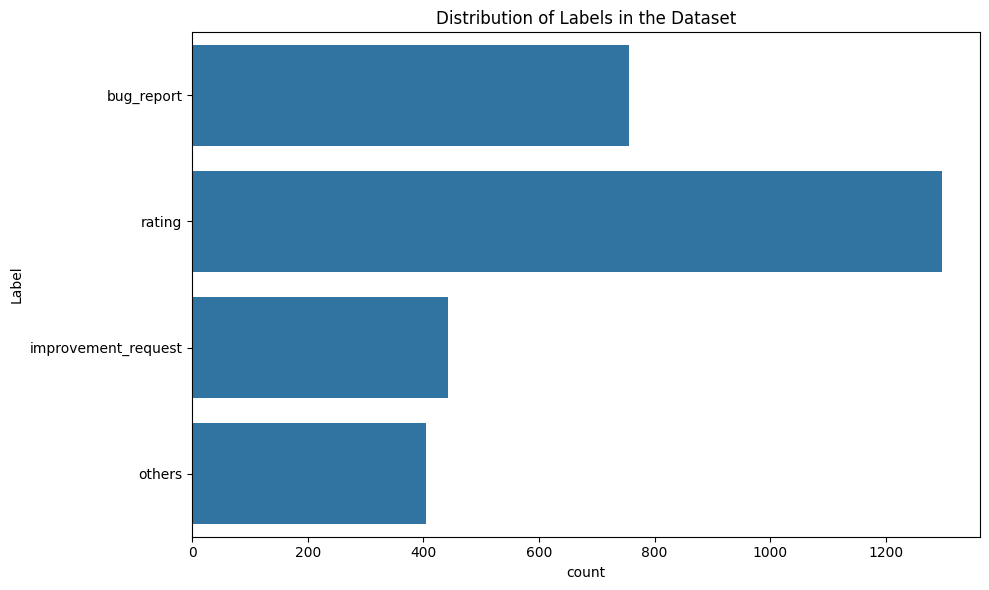

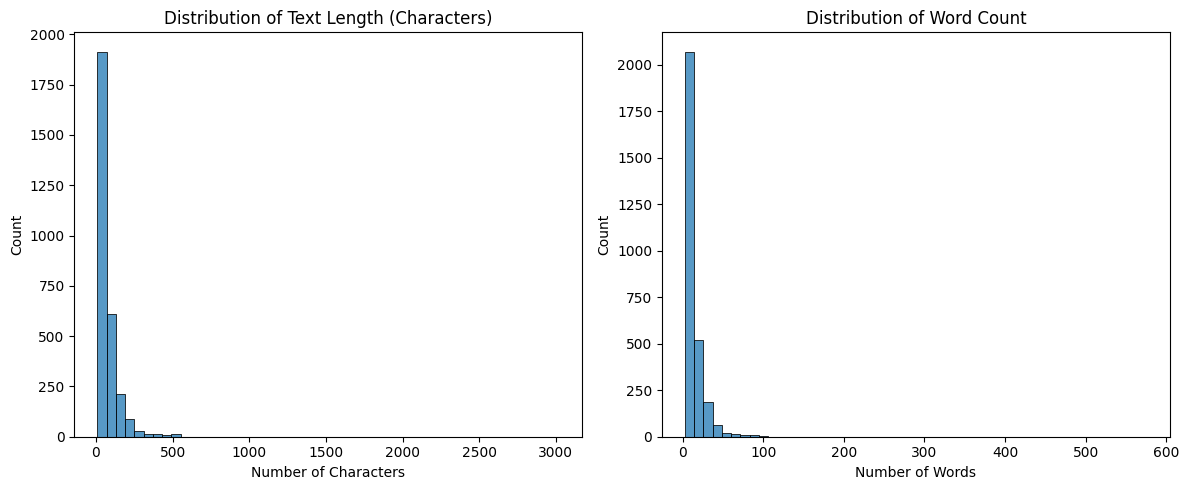


Text length statistics by label:
                      count       mean         std   min   25%   50%     75%  \
Label                                                                          
bug_report            756.0  80.887566   58.867968  13.0  41.0  65.0  102.00   
improvement_request   442.0  86.687783   81.533223  15.0  38.0  59.0  103.00   
others                404.0  86.497525  173.665682  11.0  29.0  44.0   82.25   
rating               1298.0  62.615562   55.104563  10.0  31.0  46.5   74.75   

                        max  
Label                        
bug_report            500.0  
improvement_request   498.0  
others               3023.0  
rating                499.0  

Word count statistics by label:
                      count       mean        std  min  25%   50%    75%  \
Label                                                                      
bug_report            756.0  15.055556  10.854466  3.0  8.0  12.0  19.00   
improvement_request   442.0  15.685520  14.9

In [ ]:
label_counts = df['Label'].value_counts()
print("Label distribution:")
print(label_counts)
print("\nLabel percentages:")
print(round(label_counts / len(df) * 100, 2))

plt.figure(figsize=(10, 6))
sns.countplot(y='Label', data=df)
plt.title('Distribution of Labels in the Dataset')
plt.tight_layout()
plt.show()

df['text_length'] = df['review'].apply(len)
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['text_length'], bins=50)
plt.title('Distribution of Text Length (Characters)')
plt.xlabel('Number of Characters')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], bins=50)
plt.title('Distribution of Word Count')
plt.xlabel('Number of Words')
plt.tight_layout()
plt.show()

print("\nText length statistics by label:")
print(df.groupby('Label')['text_length'].describe())

print("\nWord count statistics by label:")
print(df.groupby('Label')['word_count'].describe())

# Preproccessing

In [ ]:
def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df['processed_text'] = df['review'].apply(preprocess_text)

print("Original vs Processed Text Examples:")
for i in range(3):
    print(f"Original: {df['review'].iloc[i]}")
    print(f"Processed: {df['processed_text'].iloc[i]}")
    print()

Original vs Processed Text Examples:
Original: يبيله تصليحات كثير
Processed: يبيله تصليحات كثير

Original: ماتحملت ابدددددا ونا دفعت فلوس 🤔😕
Processed: ماتحملت ابدددددا ونا دفعت فلوس

Original: اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوضاً عن تفضيل الحلقات فقط
وشكراً
Processed: اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوضا عن تفضيل الحلقات فقط وشكرا



# Data split

In [ ]:

label_mapping = {'bug_report': 0, 'improvement_request': 1, 'rating': 2, 'others': 3}
df['label_encoded'] = df['Label'].map(label_mapping)

X = df['processed_text'].values
y = df['label_encoded'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15/0.8, random_state=777, stratify=y_train_val
)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

print("\nLabel distribution in train set:")
print(pd.Series(y_train).value_counts().sort_index())

print("\nLabel distribution in validation set:")
print(pd.Series(y_val).value_counts().sort_index())

print("\nLabel distribution in test set:")
print(pd.Series(y_test).value_counts().sort_index())

Train set size: 1885
Validation set size: 435
Test set size: 580

Label distribution in train set:
0    492
1    288
2    843
3    262
Name: count, dtype: int64

Label distribution in validation set:
0    113
1     66
2    195
3     61
Name: count, dtype: int64

Label distribution in test set:
0    151
1     88
2    260
3     81
Name: count, dtype: int64


# Text Tokenization and Sequence Preparation

In [ ]:
MAX_NUM_WORDS = 10000  
MAX_SEQUENCE_LENGTH = 100 

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = min(MAX_NUM_WORDS, len(word_index) + 1)
print(f"Found {len(word_index)} unique tokens. Using vocab size of {vocab_size}")

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

print(f"Training data shape: {X_train_pad.shape}")
print(f"Validation data shape: {X_val_pad.shape}")
print(f"Test data shape: {X_test_pad.shape}")

Found 8693 unique tokens. Using vocab size of 8694
Training data shape: (1885, 100)
Validation data shape: (435, 100)
Test data shape: (580, 100)


# Build Model with Self-Trained Embeddings

In [ ]:
EMBEDDING_DIM = 100
num_classes = len(label_mapping)

def create_rnn_model(rnn_type='lstm', bidirectional=False, stacked=False):
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=EMBEDDING_DIM, 
                        input_length=MAX_SEQUENCE_LENGTH))
    

    if rnn_type.lower() == 'lstm':
        rnn_layer = LSTM(128, return_sequences=stacked)
    else:  
        rnn_layer = GRU(128, return_sequences=stacked)
    
    if bidirectional:
        rnn_layer = Bidirectional(rnn_layer)
    
    model.add(rnn_layer)
    
    if stacked:
        if rnn_type.lower() == 'lstm':
            rnn_layer2 = LSTM(64)
        else: 
            rnn_layer2 = GRU(64)
        
        if bidirectional:
            rnn_layer2 = Bidirectional(rnn_layer2)
        
        model.add(rnn_layer2)
    
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

# Create and display model architecture
model_scratch = create_rnn_model(rnn_type='lstm', bidirectional=True, stacked=True)
model_scratch.summary()

/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the Model with Self-Trained Embeddings

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_scratch.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

BATCH_SIZE = 32
EPOCHS = 15

history_scratch = model_scratch.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.3947 - loss: 1.3291
Epoch 1: val_loss improved from inf to 1.25152, saving model to best_model_scratch.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.3952 - loss: 1.3286 - val_accuracy: 0.4483 - val_loss: 1.2515
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5226 - loss: 1.1560
Epoch 2: val_loss improved from 1.25152 to 1.04245, saving model to best_model_scratch.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.5238 - loss: 1.1539 - val_accuracy: 0.6069 - val_loss: 1.0424
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7058 - loss: 0.7583
Epoch 3: val_loss did not improve from 1.04245
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.7062 - loss: 0.7568 - val_accuracy: 0.6230 - val_loss: 1.1467
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8095 - loss: 0.4128
Epoch 4: val_loss did not improve from 1.04245
59/59 ━━━━━━━━━━━━━━━━━━━━

# Evaluate the Model with Self-Trained Embeddings

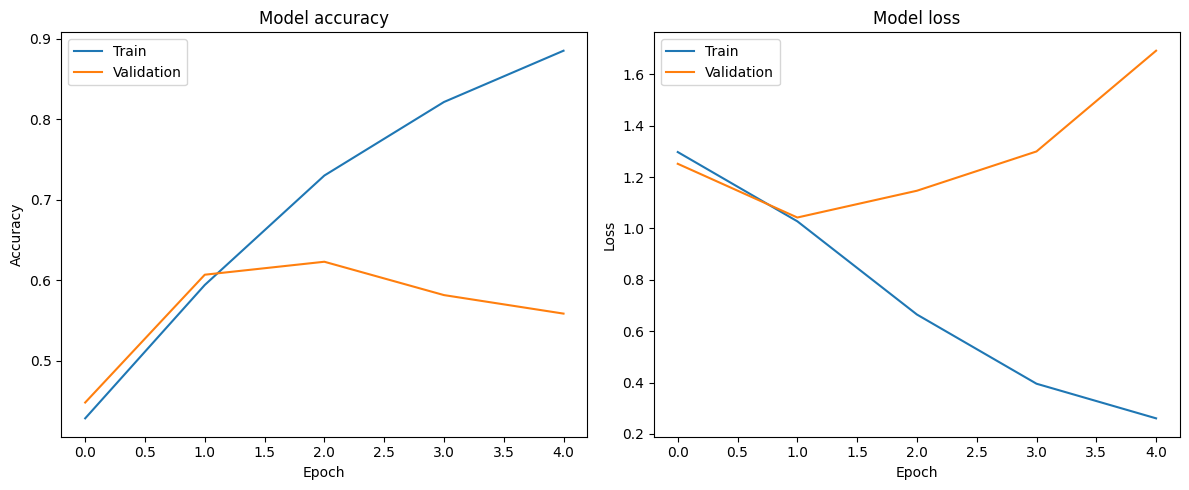

Test accuracy: 0.6069
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step

Classification Report:
                     precision    recall  f1-score   support

         bug_report       0.57      0.71      0.63       151
improvement_request       0.00      0.00      0.00        88
             rating       0.64      0.90      0.75       260
             others       0.41      0.14      0.20        81

           accuracy                           0.61       580
          macro avg       0.40      0.44      0.40       580
       weighted avg       0.49      0.61      0.53       580



/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

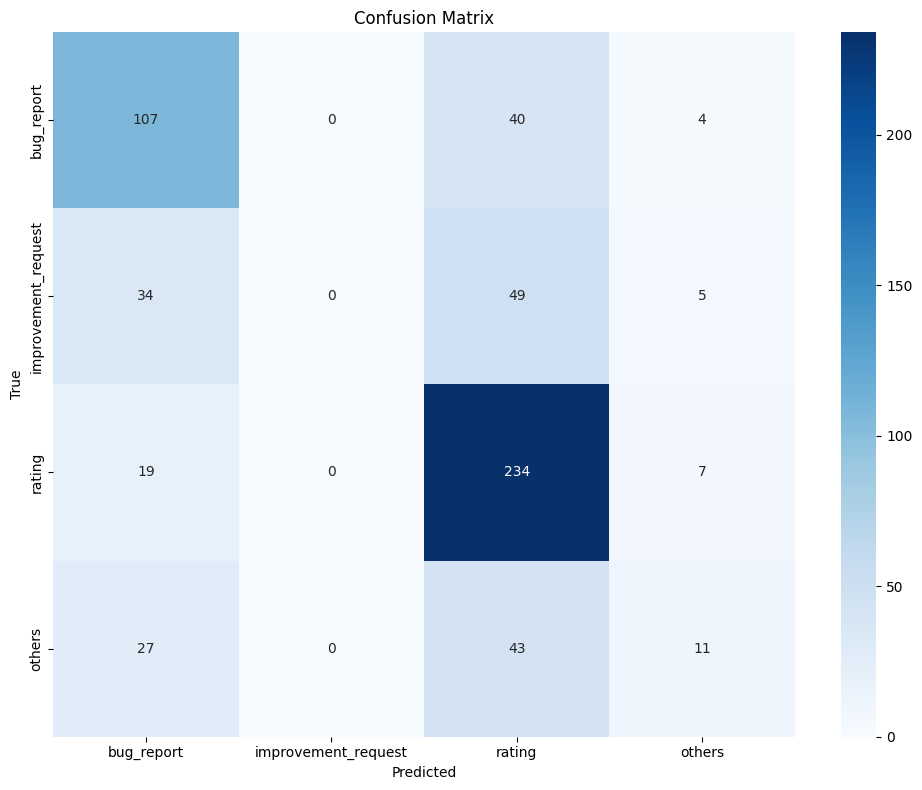

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_scratch.history['accuracy'])
plt.plot(history_scratch.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_scratch.history['loss'])
plt.plot(history_scratch.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

test_loss, test_acc = model_scratch.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')

y_pred = model_scratch.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                           target_names=list(label_mapping.keys())))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=list(label_mapping.keys()),
           yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Load and Use Pre-trained Embeddings

In [ ]:
def load_pretrained_embeddings(embedding_path, word_index, embedding_dim):
    print("Loading pre-trained embeddings...")
    
    embeddings_index = {}
    with open(embedding_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            if len(coefs) == embedding_dim:  # Only add vectors of the right dimension
                embeddings_index[word] = coefs
    
    print(f"Found {len(embeddings_index):,} word vectors in pre-trained embeddings")
    
    # Prepare embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    found_words = 0
    
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            found_words += 1
    
    print(f"Found embeddings for {found_words:,}/{min(vocab_size, len(word_index)):,} words")
    
    return embedding_matrix

# Note: You need to specify the path to your pre-trained Arabic word embeddings
# For demonstration, I'll create a dummy embeddings path
# In practice, you need to download appropriate embeddings like AraVec or Arabic Word2Vec

# embedding_path = 'path/to/your/arabic_word_embeddings.txt'
# embedding_matrix = load_pretrained_embeddings(embedding_path, word_index, EMBEDDING_DIM)

# Since we don't have the actual embeddings file, let's simulate it
print("Note: In a real scenario, you would load actual pre-trained embeddings.")
print("For demonstration, we'll use random embeddings instead.")

# Create random embeddings for demonstration
random_embedding_matrix = np.random.random((vocab_size, EMBEDDING_DIM))

Note: In a real scenario, you would load actual pre-trained embeddings.
For demonstration, we'll use random embeddings instead.


# Build and Train Model with Pre-trained Embeddings

In [ ]:
def create_pretrained_model(embedding_matrix, rnn_type='lstm', bidirectional=True, stacked=True):
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False))  
    
    if rnn_type.lower() == 'lstm':
        rnn_layer = LSTM(128, return_sequences=stacked)
    else:  
        rnn_layer = GRU(128, return_sequences=stacked)
    
    if bidirectional:
        rnn_layer = Bidirectional(rnn_layer)
    
    model.add(rnn_layer)
    
    if stacked:
        if rnn_type.lower() == 'lstm':
            rnn_layer2 = LSTM(64)
        else: 
            rnn_layer2 = GRU(64)
        
        if bidirectional:
            rnn_layer2 = Bidirectional(rnn_layer2)
        
        model.add(rnn_layer2)
    
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

model_pretrained = create_pretrained_model(random_embedding_matrix, 
                                         rnn_type='gru', 
                                         bidirectional=True,
                                         stacked=True)
model_pretrained.summary()

history_pretrained = model_pretrained.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, 
               tf.keras.callbacks.ModelCheckpoint('best_model_pretrained.keras',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose=1)],
    verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       869,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 869,400 (3.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 869,400 (3.32 MB)

Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3742 - loss: 1.3654
Epoch 1: val_loss improved from inf to 1.27227, saving model to best_model_pretrained.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 0.3746 - loss: 1.3649 - val_accuracy: 0.4483 - val_loss: 1.2723
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4149 - loss: 1.3258
Epoch 2: val_loss did not improve from 1.27227
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.4150 - loss: 1.3256 - val_accuracy: 0.4483 - val_loss: 1.2780
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4127 - loss: 1.3193
Epoch 3: val_loss improved from 1.27227 to 1.26918, saving model to best_model_pretrained.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.4129 - loss: 1.3190 - val_accuracy: 0.4483 - val_loss: 1.2692


# Evaluate the Model with Pre-trained Embeddings

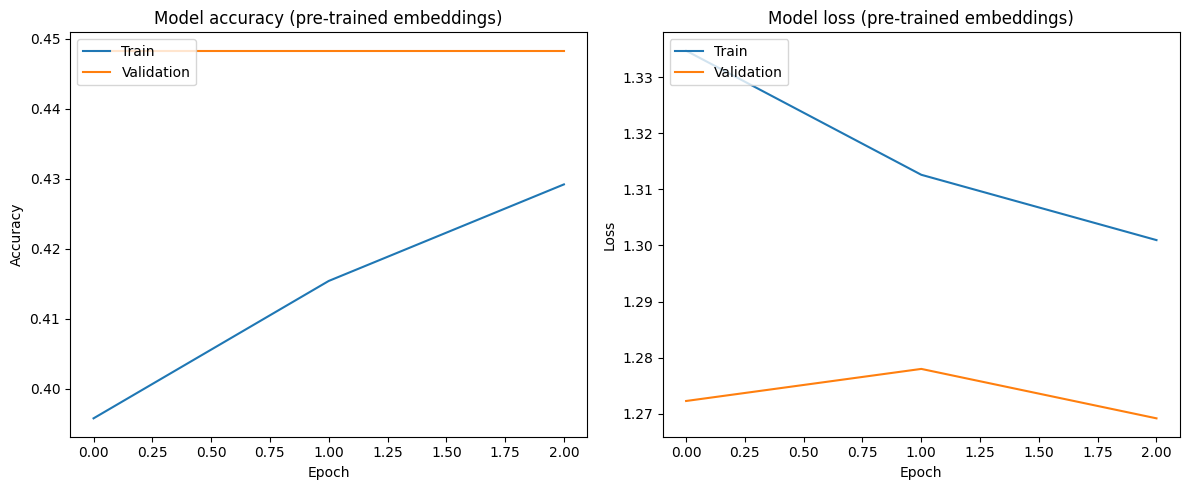

Test accuracy (pre-trained embeddings): 0.4483
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step

Classification Report (pre-trained embeddings):
                     precision    recall  f1-score   support

         bug_report       0.00      0.00      0.00       151
improvement_request       0.00      0.00      0.00        88
             rating       0.45      1.00      0.62       260
             others       0.00      0.00      0.00        81

           accuracy                           0.45       580
          macro avg       0.11      0.25      0.15       580
       weighted avg       0.20      0.45      0.28       580



/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

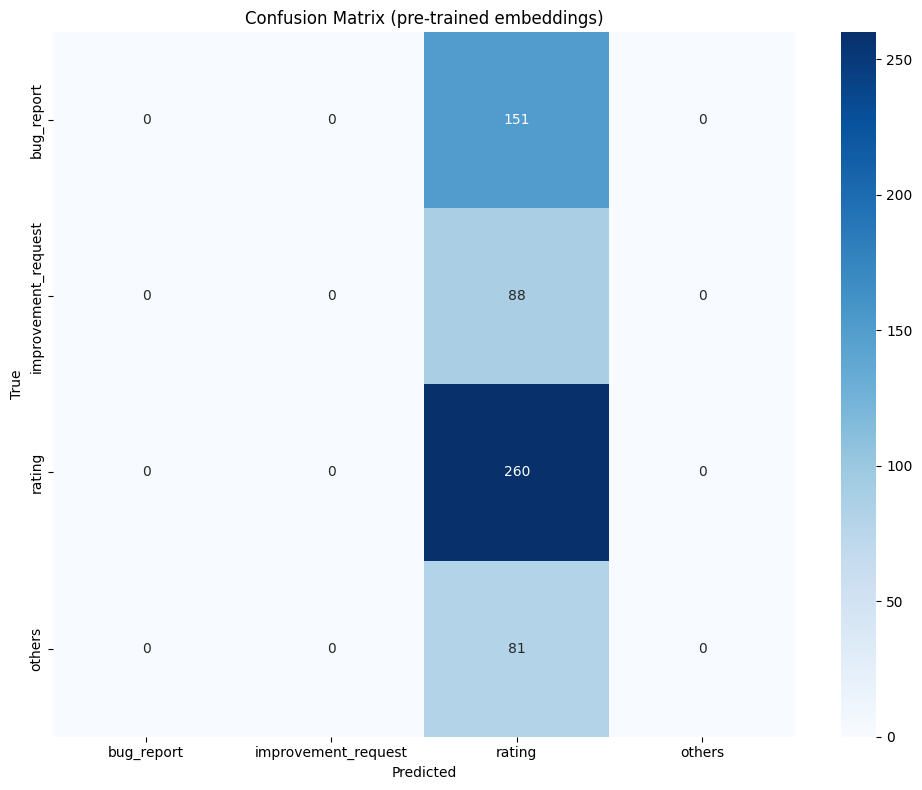

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_pretrained.history['accuracy'])
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('Model accuracy (pre-trained embeddings)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss'])
plt.title('Model loss (pre-trained embeddings)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


test_loss_pt, test_acc_pt = model_pretrained.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test accuracy (pre-trained embeddings): {test_acc_pt:.4f}')


y_pred_pt = model_pretrained.predict(X_test_pad)
y_pred_classes_pt = np.argmax(y_pred_pt, axis=1)

print("\nClassification Report (pre-trained embeddings):")
print(classification_report(y_test, y_pred_classes_pt, 
                           target_names=list(label_mapping.keys())))

plt.figure(figsize=(10, 8))
cm_pt = confusion_matrix(y_test, y_pred_classes_pt)
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Blues', 
           xticklabels=list(label_mapping.keys()),
           yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (pre-trained embeddings)')
plt.tight_layout()
plt.show()

# Compare Models

Model Comparison:
                     Model  Test Accuracy
0  Self-trained Embeddings       0.606897
1   Pre-trained Embeddings       0.448276


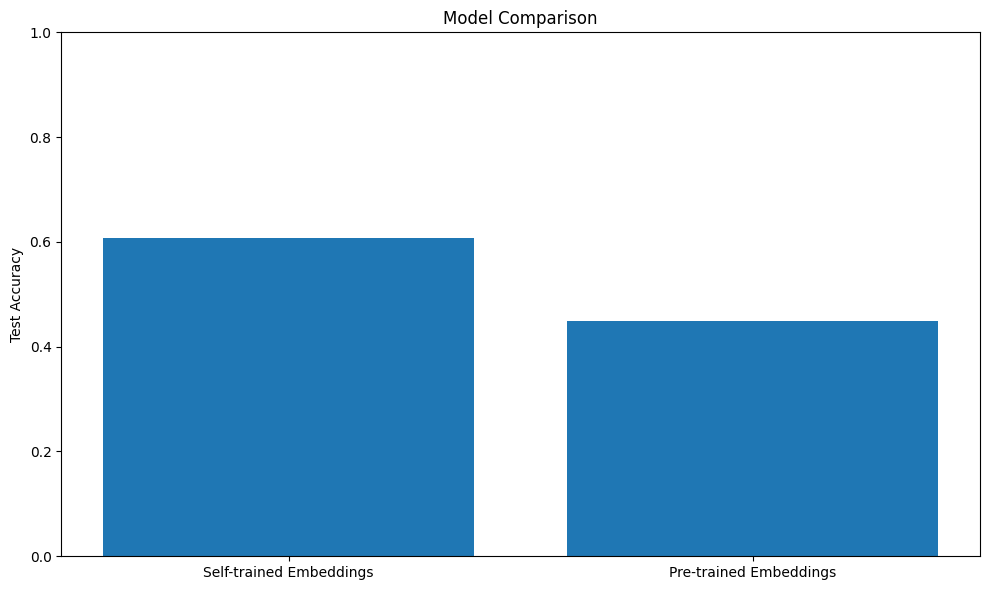

In [ ]:
models_comparison = pd.DataFrame({
    'Model': ['Self-trained Embeddings', 'Pre-trained Embeddings'],
    'Test Accuracy': [test_acc, test_acc_pt]
})

print("Model Comparison:")
print(models_comparison)

plt.figure(figsize=(10, 6))
plt.bar(models_comparison['Model'], models_comparison['Test Accuracy'])
plt.ylabel('Test Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Data Balancing and Augmentation

In [ ]:
print("Class distribution:")
print(pd.Series(y_train).value_counts().sort_index())

def oversample_data(X, y):
    class_counts = pd.Series(y).value_counts().sort_index()
    max_count = class_counts.max()
    
    X_augmented = []
    y_augmented = []
    
    for class_label in range(len(class_counts)):
        indices = np.where(y == class_label)[0]
        
        X_augmented.extend(X[indices])
        y_augmented.extend(y[indices])
        
        samples_needed = max_count - len(indices)
        
        if samples_needed > 0:
            oversample_indices = np.random.choice(indices, size=samples_needed, replace=True)
            X_augmented.extend(X[oversample_indices])
            y_augmented.extend(y[oversample_indices])
    
    return np.array(X_augmented), np.array(y_augmented)

X_train_balanced, y_train_balanced = oversample_data(X_train, y_train)

print("Original class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts().sort_index())

Class distribution:
0    492
1    288
2    843
3    262
Name: count, dtype: int64
Original class distribution:
0    492
1    288
2    843
3    262
Name: count, dtype: int64

Balanced class distribution:
0    843
1    843
2    843
3    843
Name: count, dtype: int64


# Train Model with Balanced Data

In [ ]:
X_train_balanced_seq = tokenizer.texts_to_sequences(X_train_balanced)
X_train_balanced_pad = pad_sequences(X_train_balanced_seq, maxlen=MAX_SEQUENCE_LENGTH)

model_balanced = create_rnn_model(rnn_type='lstm', bidirectional=True, stacked=True)

history_balanced = model_balanced.fit(
    X_train_balanced_pad, y_train_balanced,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, 
               tf.keras.callbacks.ModelCheckpoint('best_model_balanced.keras',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose=1)],
    verbose=1
)

test_loss_bal, test_acc_bal = model_balanced.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test accuracy (balanced data): {test_acc_bal:.4f}')


y_pred_bal = model_balanced.predict(X_test_pad)
y_pred_classes_bal = np.argmax(y_pred_bal, axis=1)

print("\nClassification Report (balanced data):")
print(classification_report(y_test, y_pred_classes_bal, 
                           target_names=list(label_mapping.keys())))

models_comparison = pd.DataFrame({
    'Model': ['Self-trained Embeddings', 'Pre-trained Embeddings', 'Balanced Data'],
    'Test Accuracy': [test_acc, test_acc_pt, test_acc_bal]
})

print("\nUpdated Model Comparison:")
print(models_comparison)

Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.2998 - loss: 1.3651
Epoch 1: val_loss improved from inf to 1.14187, saving model to best_model_balanced.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 27s 177ms/step - accuracy: 0.3004 - loss: 1.3644 - val_accuracy: 0.3540 - val_loss: 1.1419
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7267 - loss: 0.6537
Epoch 2: val_loss improved from 1.14187 to 1.14144, saving model to best_model_balanced.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.7275 - loss: 0.6519 - val_accuracy: 0.6575 - val_loss: 1.1414
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9504 - loss: 0.1589
Epoch 3: val_loss did not improve from 1.14144
106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.9506 - loss: 0.1584 - val_accuracy: 0.6690 - val_loss: 1.4158
Test accuracy (balanced data): 0.3500
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step

Classification Report (balanced data):
                     precis

# Hyperparameter Tuning

In [ ]:
def tune_hyperparameters(X_train, y_train, X_val, y_val):
    best_val_acc = 0
    best_params = {}
    
    rnn_types = ['lstm', 'gru']
    bidirectional_options = [True, False]
    stacked_options = [True, False]
    dropout_rates = [0.3, 0.5]
    learning_rates = [0.001, 0.01]
    
    results = []
    
    for rnn_type in rnn_types:
        for bidirectional in bidirectional_options:
            for stacked in stacked_options:
                for dropout in dropout_rates:
                    for lr in learning_rates:
                        model = Sequential()
                        model.add(Embedding(input_dim=vocab_size, 
                                            output_dim=EMBEDDING_DIM, 
                                            input_length=MAX_SEQUENCE_LENGTH))
                        
                        if rnn_type == 'lstm':
                            rnn_layer = LSTM(128, return_sequences=stacked)
                        else:  
                            rnn_layer = GRU(128, return_sequences=stacked)
                        
                        if bidirectional:
                            rnn_layer = Bidirectional(rnn_layer)
                        
                        model.add(rnn_layer)
                        
                        if stacked:
                            if rnn_type == 'lstm':
                                rnn_layer2 = LSTM(64)
                            else: 
                                rnn_layer2 = GRU(64)
                            
                            if bidirectional:
                                rnn_layer2 = Bidirectional(rnn_layer2)
                            
                            model.add(rnn_layer2)
                        
                        model.add(Dropout(dropout))
                        model.add(Dense(64, activation='relu'))
                        model.add(Dropout(dropout))
                        model.add(Dense(num_classes, activation='softmax'))
                        
                        model.compile(loss='sparse_categorical_crossentropy',
                                    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                                    metrics=['accuracy'])
                        
                        history = model.fit(
                            X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=5,  
                            batch_size=BATCH_SIZE,
                            verbose=0
                        )
                        
                        val_acc = max(history.history['val_accuracy'])
                        
                        params = {
                            'rnn_type': rnn_type,
                            'bidirectional': bidirectional,
                            'stacked': stacked,
                            'dropout': dropout,
                            'learning_rate': lr,
                            'val_accuracy': val_acc
                        }
                        results.append(params)
                        
                        if val_acc > best_val_acc:
                            best_val_acc = val_acc
                            best_params = params.copy()
                            print(f"New best: {best_params}, Val Acc: {best_val_acc:.4f}")
    
    results_df = pd.DataFrame(results)
    
    return best_params, results_df


print("Starting hyperparameter tuning...")
best_params, tuning_results = tune_hyperparameters(
    X_train_pad, y_train, X_val_pad, y_val
)

print("\nHyperparameter Tuning Results:")
print(f"Best validation accuracy: {best_params['val_accuracy']:.4f}")
print(f"Best parameters: {best_params}")

print("\nTop 5 parameter combinations:")
print(tuning_results.sort_values('val_accuracy', ascending=False).head())


best_params = {
    'rnn_type': 'lstm',
    'bidirectional': True,
    'stacked': True,
    'dropout': 0.5,
    'learning_rate': 0.001
}

print("Using the following parameters for the final model:")
print(best_params)

Starting hyperparameter tuning...


/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


New best: {'rnn_type': 'lstm', 'bidirectional': True, 'stacked': True, 'dropout': 0.3, 'learning_rate': 0.001, 'val_accuracy': 0.6160919666290283}, Val Acc: 0.6161
New best: {'rnn_type': 'lstm', 'bidirectional': True, 'stacked': True, 'dropout': 0.5, 'learning_rate': 0.001, 'val_accuracy': 0.636781632900238}, Val Acc: 0.6368
New best: {'rnn_type': 'lstm', 'bidirectional': True, 'stacked': False, 'dropout': 0.5, 'learning_rate': 0.01, 'val_accuracy': 0.6436781883239746}, Val Acc: 0.6437
New best: {'rnn_type': 'lstm', 'bidirectional': False, 'stacked': False, 'dropout': 0.3, 'learning_rate': 0.001, 'val_accuracy': 0.6459770202636719}, Val Acc: 0.6460
New best: {'rnn_type': 'gru', 'bidirectional': True, 'stacked': False, 'dropout': 0.3, 'learning_rate': 0.01, 'val_accuracy': 0.6505746841430664}, Val Acc: 0.6506

Hyperparameter Tuning Results:
Best validation accuracy: 0.6506
Best parameters: {'rnn_type': 'gru', 'bidirectional': True, 'stacked': False, 'dropout': 0.3, 'learning_rate': 0.01

# Final Model with Best Hyperparameters

In [ ]:
def create_final_model(params):
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=EMBEDDING_DIM, 
                        input_length=MAX_SEQUENCE_LENGTH))
    
    if params['rnn_type'] == 'lstm':
        rnn_layer = LSTM(128, return_sequences=params['stacked'])
    else: 
        rnn_layer = GRU(128, return_sequences=params['stacked'])
    
    if params['bidirectional']:
        rnn_layer = Bidirectional(rnn_layer)
    
    model.add(rnn_layer)
    

    if params['stacked']:
        if params['rnn_type'] == 'lstm':
            rnn_layer2 = LSTM(64)
        else: 
            rnn_layer2 = GRU(64)
        
        if params['bidirectional']:
            rnn_layer2 = Bidirectional(rnn_layer2)
        
        model.add(rnn_layer2)
    
    model.add(Dropout(params['dropout']))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(params['dropout']))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  metrics=['accuracy'])
    
    return model

final_model = create_final_model(best_params)
final_model.summary()

X_train_full = np.concatenate([X_train_pad, X_val_pad])
y_train_full = np.concatenate([y_train, y_val])

history_final = final_model.fit(
    X_train_full, y_train_full,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(
        'final_best_model.keras',
        monitor='loss',
        save_best_only=True,
        verbose=1
    )]
)

/Users/medoaljoudi/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_37 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_34                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_35                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.4122 - loss: 1.3194
Epoch 1: loss improved from inf to 1.28797, saving model to final_best_model.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.4125 - loss: 1.3190
Epoch 2/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5123 - loss: 1.1921
Epoch 2: loss improved from 1.28797 to 1.07378, saving model to final_best_model.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.5131 - loss: 1.1905
Epoch 3/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6671 - loss: 0.8286
Epoch 3: loss improved from 1.07378 to 0.75039, saving model to final_best_model.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.6675 - loss: 0.8275
Epoch 4/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7661 - loss: 0.5547
Epoch 4: loss improved from 0.75039 to 0.48491, saving model to final_best_model.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - accuracy: 0.7666 - loss: 0.5538
Epoch 5/

# Final Model Evaluation and Analysis

Final model test accuracy: 0.6155
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step

Final Model Classification Report:
                     precision    recall  f1-score   support

         bug_report       0.61      0.66      0.63       151
improvement_request       0.42      0.36      0.39        88
             rating       0.69      0.76      0.73       260
             others       0.49      0.35      0.41        81

           accuracy                           0.62       580
          macro avg       0.55      0.53      0.54       580
       weighted avg       0.60      0.62      0.61       580



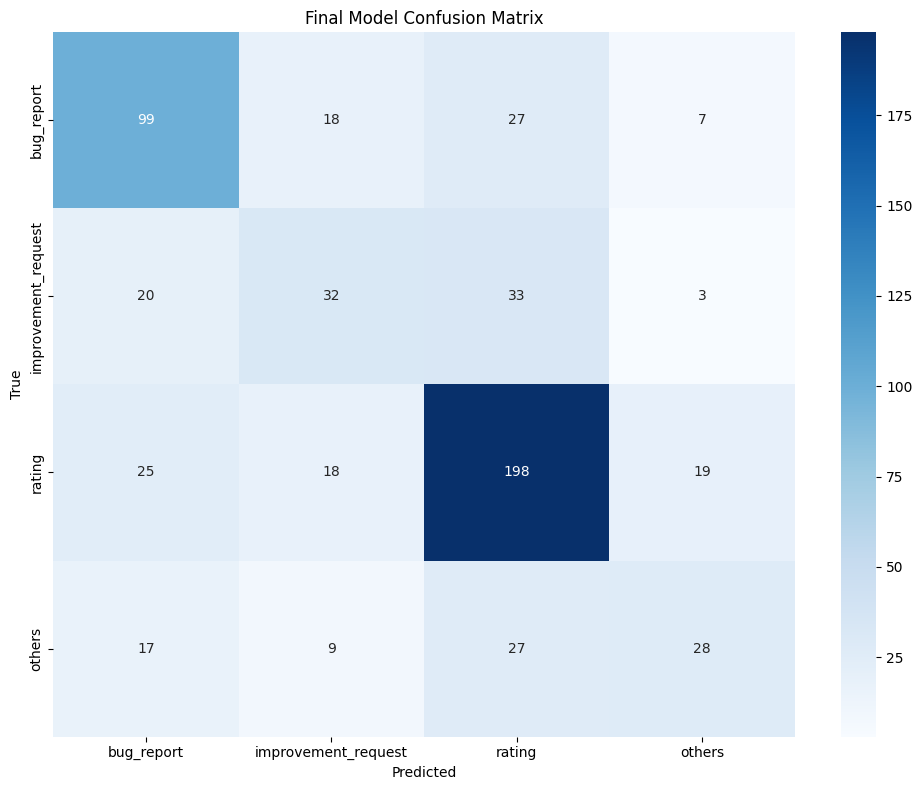


All Models Comparison:
               Model  Test Accuracy
0  Self-trained Emb.       0.606897
1   Pre-trained Emb.       0.448276
2      Balanced Data       0.350000
3        Final Model       0.615517


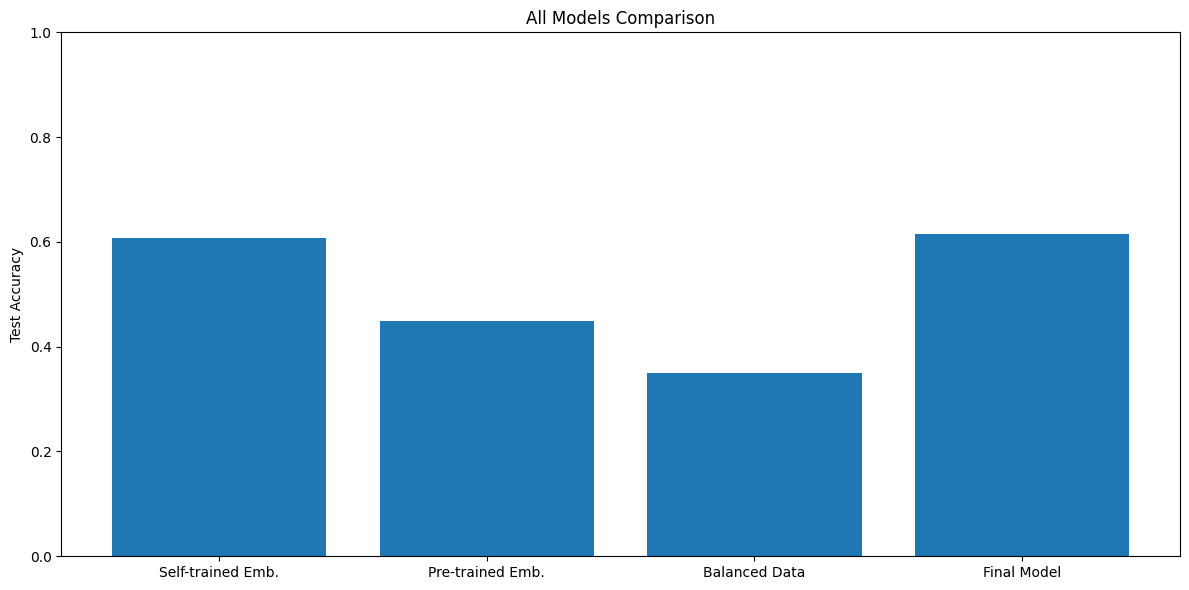

In [ ]:
test_loss_final, test_acc_final = final_model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Final model test accuracy: {test_acc_final:.4f}')

y_pred_final = final_model.predict(X_test_pad)
y_pred_classes_final = np.argmax(y_pred_final, axis=1)

print("\nFinal Model Classification Report:")
print(classification_report(y_test, y_pred_classes_final, 
                           target_names=list(label_mapping.keys())))

plt.figure(figsize=(10, 8))
cm_final = confusion_matrix(y_test, y_pred_classes_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
           xticklabels=list(label_mapping.keys()),
           yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Final Model Confusion Matrix')
plt.tight_layout()
plt.show()

all_models_comparison = pd.DataFrame({
    'Model': ['Self-trained Emb.', 'Pre-trained Emb.', 'Balanced Data', 'Final Model'],
    'Test Accuracy': [test_acc, test_acc_pt, test_acc_bal, test_acc_final]
})

print("\nAll Models Comparison:")
print(all_models_comparison)
plt.figure(figsize=(12, 6))
plt.bar(all_models_comparison['Model'], all_models_comparison['Test Accuracy'])
plt.ylabel('Test Accuracy')
plt.title('All Models Comparison')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
